## Detect PhiDP folds

Based on code written by Valentin Louf, this code will detect if there are PhiDP folds in a scan 
and correct velocities. Further, it will give the range of the closest fold. For multidop, we are only
concerned with such folds within 60 km of CPOL

In [163]:
import pyart
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
from csu_radartools import csu_kdp
from copy import deepcopy
from numba import jit, int32, float32

In [164]:
radar_file = '/home/rjackson/data/radar/cpol/Gunn_pt_20060306185001ppi.nc'
radar = pyart.io.read(radar_file)

## Plot Raw and (current) corrected velocity

(-50, 0)

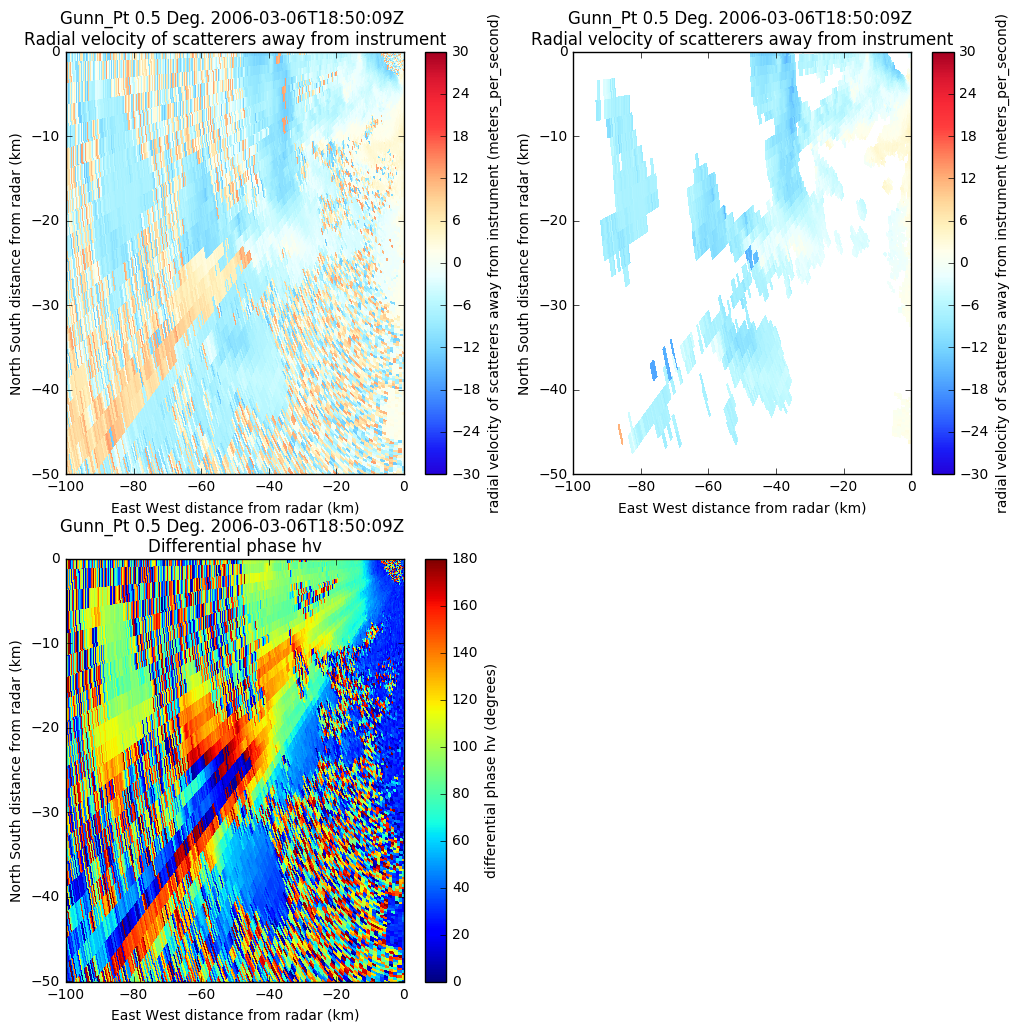

In [165]:
display = pyart.graph.RadarMapDisplay(radar)
plt.figure(figsize=(12,12))
gatefilter = pyart.filters.GateFilter(radar)
plt.subplot(221)
display.plot_ppi('velocity', gatefilter=gatefilter)
plt.xlim([-100,0])
plt.ylim([-50,0])
plt.subplot(222)
display.plot_ppi('corrected_velocity', 
                 gatefilter=gatefilter)
plt.xlim([-100,0])
plt.ylim([-50,0])
plt.subplot(223)
display.plot_ppi('differential_phase', 
                 gatefilter=gatefilter,
                 cmap='jet', vmin=0, vmax=180)
plt.xlim([-100,0])
plt.ylim([-50,0])

## KDP processing

Code based on notebook from Valentin Louf

In [166]:
def extract_unmasked_data(radar, field, bad=-32768):
    """Simplify getting unmasked radar fields from Py-ART"""
    return deepcopy(radar.fields[field]['data'].filled(fill_value=bad))

In [167]:
dz = extract_unmasked_data(radar, 'reflectivity')
dp = extract_unmasked_data(radar, 'differential_phase')
r, azi = radar.range['data'], radar.azimuth['data']
rng2d, az2d = np.meshgrid(radar.range['data'], radar.azimuth['data'])

In [168]:
kdN, fdN, sdN = csu_kdp.calc_kdp_bringi(dp=dp, dz=dz, rng=rng2d/1000.0, thsd=24, gs=250.0, window=4)

In [169]:
kdN = np.ma.MaskedArray(kdN)
kdN[kdN == -32768] = np.ma.masked

fdN = np.ma.MaskedArray(fdN)
fdN[fdN == -32768] = np.ma.masked

sdN = np.ma.MaskedArray(sdN)
sdN[sdN == -32768] = np.ma.masked

In [170]:
radar.add_field('specific_differential_phase',
                {'data': kdN, 
                 'long_name:': 'Specific differential phase',
                 'units': 'deg/m'},
                replace_existing=True)
radar.add_field_like('differential_phase', 
                     'new_phidp', 
                     fdN, 
                     replace_existing=True)
radar.add_field('SDP', 
                {'data':kdN, 'long_name':'Standard Deviation of Differential Phase', 'units':''}, 
                replace_existing=True)

(-50, 0)

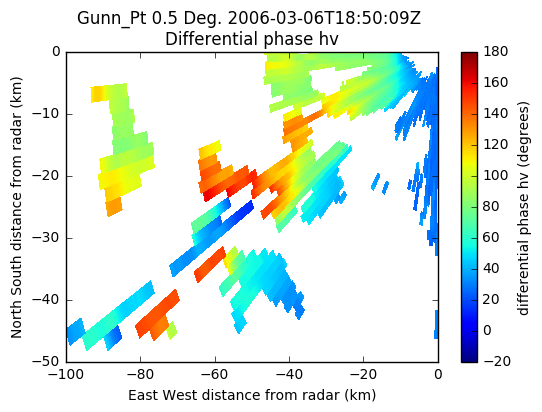

In [171]:
display.plot_ppi('new_phidp', vmin=-20, vmax=180)
plt.xlim([-100,0])
plt.ylim([-50,0])

## Unfold phiDP

In [172]:
@jit(nopython=True, cache=True)
def get_fold_position(the_phidp):
    tmp = the_phidp
    rth_pos = np.zeros((tmp.shape[0]), dtype=np.int32)    
    for j in range(tmp.shape[0]):
        for i in range(50, tmp.shape[1]):
            if the_phidp[j, i] < -20:    
                rth_pos[j] = i
                break
                
    return rth_pos

@jit(nopython=True, cache=True)
def unfold_phidp(the_phidp, rth_position):
    tmp = the_phidp
    for j in range(len(rth_position)):
        i = rth_position[j]
        if i == 0:
            continue
        else:
            tmp[j, i:] += 180
    return tmp

In [173]:
# No NCP, set to 1 everywhere
NCP = np.ones(fdN.shape)
NCP[fdN == -32768] = 0
radar.add_field_like('corrected_velocity', 
                     'normalized_coherent_power', 
                     NCP, 
                     replace_existing = True)
print(radar.fields.keys())

dict_keys(['differential_reflectivity', 'normalized_coherent_power', 'new_phidp', 'SDP', 'reflectivity', 'velocity', 'specific_differential_phase', 'cross_correlation_ratio', 'spectrum_width', 'differential_phase', 'corrected_velocity'])


(4131, 480)


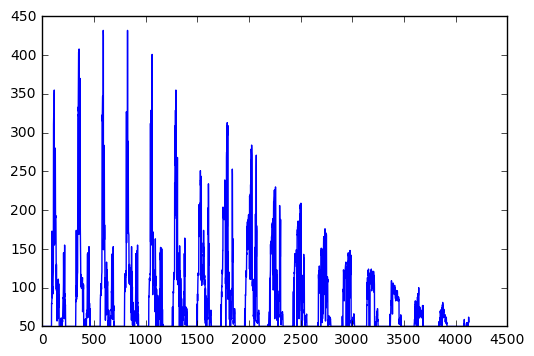

In [174]:
position = get_fold_position(fdN)
unf_phidp = unfold_phidp(fdN, position)
print(unf_phidp.shape)
radar.add_field_like('new_phidp', 
                     'unfolded_phidp', 
                     unf_phidp, 
                     replace_existing = True)
plt.plot(position)

(-50, 0)

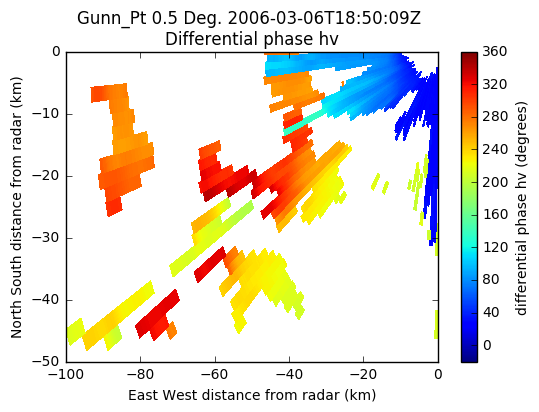

In [175]:
gatefilter = pyart.filters.GateFilter(radar)
gatefilter.exclude_masked('new_phidp')
display.plot_ppi('unfolded_phidp', gatefilter=gatefilter, 
                 cmap='jet', vmin=-20, vmax=360)
plt.xlim([-100,0])
plt.ylim([-50,0])